In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
nltk.download('stopwards')

[nltk_data] Error loading stopwards: Package 'stopwards' not found in
[nltk_data]     index


False

In [7]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> stopwords
Command 'stopwords' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Asses

True

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")

In [10]:
def load_dataset(filepath):
    data = []
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            data.append(line.strip().split(";"))
    return pd.DataFrame(data, columns = ["text", "emotion"])


In [11]:
train_data = load_dataset("/content/train.txt")
validation_data = load_dataset("/content/val.txt")
test_data = load_dataset("/content/test.txt") 

In [18]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [25]:
df = pd.concat([train_data, validation_data, test_data])

In [26]:
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [27]:
df['emotion'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: emotion, dtype: int64

In [28]:
df.isnull().sum()

text       0
emotion    0
dtype: int64

In [29]:
df.duplicated().sum()

1

In [30]:
df.drop_duplicates(inplace = True)

In [31]:
df.duplicated().sum()

0

In [32]:
len(df)

19999

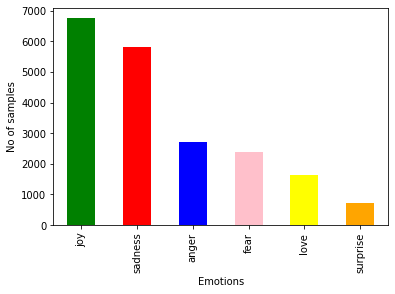

In [33]:
df['emotion'].value_counts().plot(kind='bar', color = ['green', 'red', 'blue', 'pink', 'yellow', 'orange'])
plt.xlabel('Emotions')
plt.ylabel('No of samples')
plt.show()
                                  

ValueError: ignored

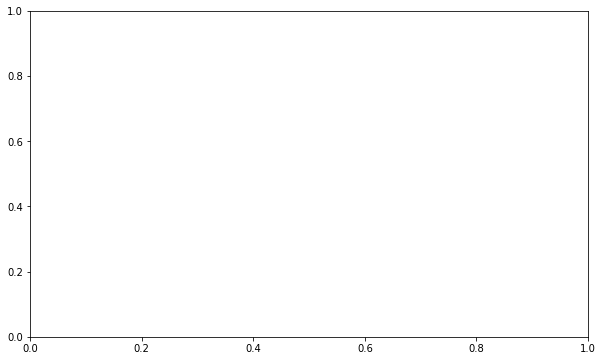

In [34]:
df['length'] = df.text.apply(lambda x:len(x))
fig = plt.figure(figsize=(10,6))
sns.kdeplot(x=df['length'], hue=df["emotion"])
plt.show()

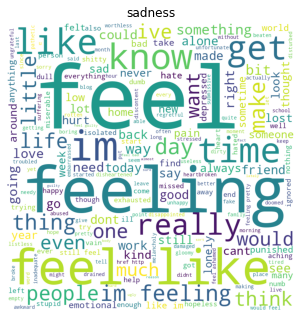

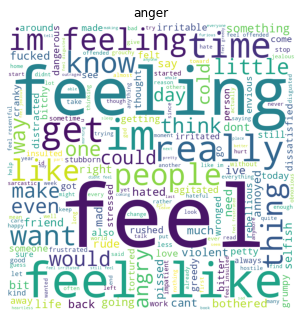

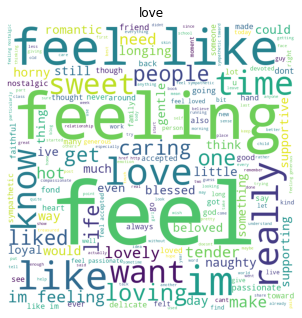

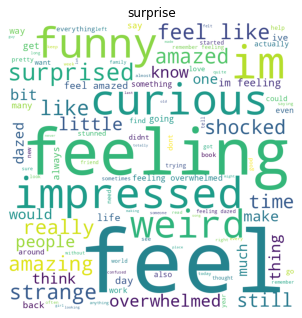

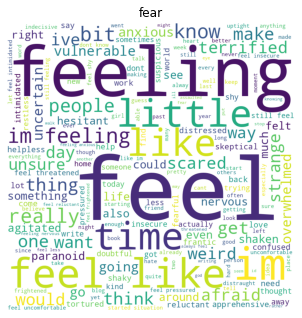

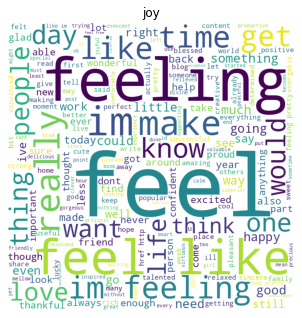

In [35]:
emotions = df['emotion'].unique()
for emotion in emotions:
    text = " ".join(df[df['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(text)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(emotion)
    plt.show()


In [36]:
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text.lower())
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    preprocessed_text = " ".join(lemmatized_tokens)
    return preprocessed_text

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [42]:
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [43]:
df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) if not word.endswith('ing') else stemmer.stem(word[:-3]) for word in x.split()]))
df["text"] = df["text"].apply(lambda x: preprocess_text(x))

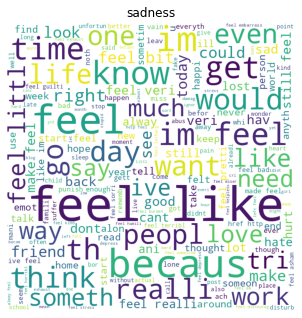

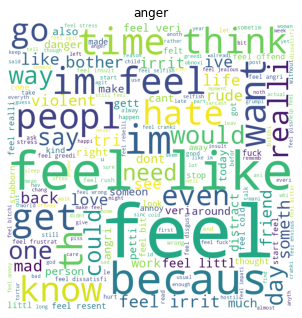

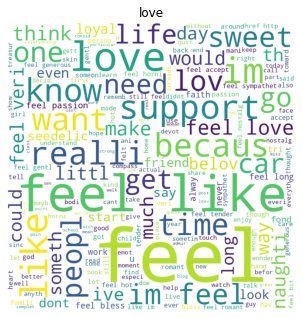

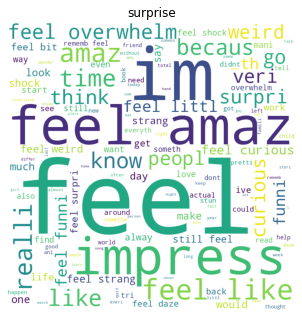

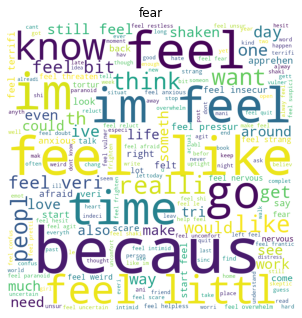

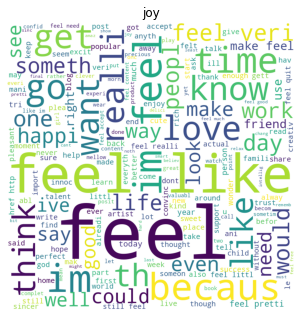

In [44]:
emotions = df['emotion'].unique()
for emotion in emotions:
    text = " ".join(df[df['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(text)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(emotion)
    plt.show()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["emotion"], test_size=0.2, random_state=100)


In [46]:
cv = CountVectorizer()
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

MACHINE LEARNING MODELS

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=100)
rf.fit(x_train_cv, y_train)


RandomForestClassifier(random_state=100)

In [50]:
y_pred_rf = rf.predict(x_test_cv)


In [51]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest classifier:", accuracy_rf)


Accuracy of Random Forest classifier: 0.85525


In [52]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification report of Random Forest classifier:\n", report_rf)

Classification report of Random Forest classifier:
               precision    recall  f1-score   support

       anger       0.81      0.90      0.85       538
        fear       0.84      0.83      0.83       494
         joy       0.89      0.87      0.88      1316
        love       0.77      0.69      0.73       326
     sadness       0.90      0.89      0.90      1198
    surprise       0.66      0.72      0.69       128

    accuracy                           0.86      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.86      0.86      0.86      4000



In [54]:
lr = LogisticRegression(max_iter=1000, random_state=100)
lr.fit(x_train_cv, y_train)

LogisticRegression(max_iter=1000, random_state=100)

In [55]:
y_pred_lr = lr.predict(x_test_cv)


In [56]:
report_lr = classification_report(y_test, y_pred_lr)
print("Classification report of Logistic Regression (Multi-Class):\n", report_lr)


Classification report of Logistic Regression (Multi-Class):
               precision    recall  f1-score   support

       anger       0.87      0.82      0.84       538
        fear       0.86      0.80      0.83       494
         joy       0.86      0.91      0.88      1316
        love       0.77      0.67      0.72       326
     sadness       0.90      0.92      0.91      1198
    surprise       0.68      0.70      0.69       128

    accuracy                           0.86      4000
   macro avg       0.82      0.80      0.81      4000
weighted avg       0.86      0.86      0.86      4000



In [57]:
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)


MultinomialNB()

In [58]:
y_pred_nb = nb.predict(x_test_cv)

In [60]:
report_nb = classification_report(y_test, y_pred_nb)

In [61]:
print("Classification report of Navie Bayes:\n", report_nb)


Classification report of Navie Bayes:
               precision    recall  f1-score   support

       anger       0.86      0.65      0.74       538
        fear       0.87      0.61      0.72       494
         joy       0.74      0.93      0.82      1316
        love       0.87      0.31      0.46       326
     sadness       0.75      0.92      0.83      1198
    surprise       0.70      0.05      0.10       128

    accuracy                           0.77      4000
   macro avg       0.80      0.58      0.61      4000
weighted avg       0.79      0.77      0.75      4000



In [63]:
svm = LinearSVC(random_state=100)
svm.fit(x_train_cv, y_train)


LinearSVC(random_state=100)

In [64]:
y_pred_svm = svm.predict(x_test_cv)


In [65]:
report_svm = classification_report(y_test, y_pred_svm)
print("Classification report of Linear SVM:\n", report_svm)

Classification report of Linear SVM:
               precision    recall  f1-score   support

       anger       0.85      0.83      0.84       538
        fear       0.84      0.83      0.84       494
         joy       0.86      0.89      0.87      1316
        love       0.72      0.65      0.68       326
     sadness       0.90      0.91      0.91      1198
    surprise       0.72      0.73      0.72       128

    accuracy                           0.86      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.85      0.86      0.85      4000



In [66]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
emotions = le.classes_

In [67]:
emotions

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [69]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)


In [70]:
x_train_seq

[[750, 288, 160, 589, 1, 509, 252, 81],
 [1157, 2493, 365, 644, 1, 813],
 [1,
  2,
  30,
  2,
  91,
  3941,
  4,
  37,
  112,
  392,
  344,
  1085,
  783,
  38,
  76,
  412,
  1158,
  992,
  510,
  1197],
 [42, 176, 495, 203, 94, 176, 654, 38, 203, 42, 176, 1, 172],
 [2825, 2826, 25, 1, 258, 246, 563, 145],
 [7, 701, 2494, 2, 3, 247, 765, 590, 46, 2278, 850, 1, 426],
 [3, 993, 564, 565, 1198, 31, 316, 4, 193, 32, 316, 124, 1, 357, 36],
 [194, 3, 7, 1, 1159, 178, 155, 317, 2495, 2496, 451, 317],
 [1, 566, 2827, 627, 24, 282, 164],
 [1, 9, 277, 35],
 [14, 1, 690, 1739, 2497, 2497, 1365, 26, 2498, 195, 226],
 [32, 591, 1, 187, 609, 469, 589, 3942, 2499, 110, 1321, 3249, 3943, 2500],
 [63, 366, 29, 71, 258, 95, 1, 691, 15, 27, 316, 1, 579],
 [51, 44, 1, 470, 164, 26, 2828],
 [1740, 2279, 15, 199, 218, 1968, 1, 860, 120, 567, 40, 994, 347, 851],
 [1, 259, 1549, 1550, 27, 1049, 67, 873, 692, 156, 1, 2, 609, 344, 77],
 [1050, 100, 345, 1, 8, 11, 385, 28, 182],
 [11, 2096, 1, 1019, 218, 675, 2

In [71]:
max_len = max(len(seq) for seq in x_train_seq)
x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [72]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32, input_length=max_len))
model.add(LSTM(32))
model.add(Dense(len(emotions), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train_padded, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
400/400 [==============================] - 19s 36ms/step - loss: 1.4869 - accuracy: 0.3621 - val_loss: 1.2024 - val_accuracy: 0.4409
Epoch 2/30
400/400 [==============================] - 10s 26ms/step - loss: 1.1197 - accuracy: 0.4739 - val_loss: 1.1032 - val_accuracy: 0.4959
Epoch 3/30
400/400 [==============================] - 11s 26ms/step - loss: 0.9205 - accuracy: 0.6079 - val_loss: 0.9501 - val_accuracy: 0.6247
Epoch 4/30
400/400 [==============================] - 11s 27ms/step - loss: 0.7039 - accuracy: 0.7104 - val_loss: 0.7434 - val_accuracy: 0.7053
Epoch 5/30
400/400 [==============================] - 11s 28ms/step - loss: 0.5489 - accuracy: 0.7858 - val_loss: 0.6502 - val_accuracy: 0.7738
Epoch 6/30
400/400 [==============================] - 11s 26ms/step - loss: 0.4111 - accuracy: 0.8680 - val_loss: 0.5264 - val_accuracy: 0.8406
Epoch 7/30
400/400 [==============================] - 10s 25ms/step - loss: 0.2854 - accuracy: 0.9148 - val_loss: 0.5462 - val_accuracy:

In [74]:
y_pred = model.predict(x_test_padded)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=emotions)
print("Accuracy:", accuracy)
print("Classification report of LSTM:\n", report)

125/125 [==============================] - 1s 7ms/step
Accuracy: 0.862
Classification report of LSTM:
               precision    recall  f1-score   support

       anger       0.87      0.84      0.85       538
        fear       0.86      0.84      0.85       494
         joy       0.91      0.90      0.90      1316
        love       0.69      0.68      0.69       326
     sadness       0.88      0.92      0.90      1198
    surprise       0.65      0.59      0.61       128

    accuracy                           0.86      4000
   macro avg       0.81      0.79      0.80      4000
weighted avg       0.86      0.86      0.86      4000

